# 案例分析
# 武汉 - 湖北（除武汉外） - 湖北以外 疫情对比

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import utils   # some convenient functions
import matplotlib.font_manager as mfm
font_path = './STFANGSO.TTF'
font_prop = mfm.FontProperties(fname=font_path)

%load_ext autoreload
%autoreload 2

In [2]:
data = utils.load_chinese_data()
daily_frm = utils.aggDaily(data)

In [3]:
wuhan = daily_frm[daily_frm['cityName'] == '武汉'].groupby('updateDate').agg('sum')
hubei_exWuhan = daily_frm[(daily_frm['provinceName'] == '湖北省') & (daily_frm['cityName'] != '武汉')].groupby('updateDate').agg('sum')
china_exHubei = daily_frm[daily_frm['provinceName'] != '湖北省'].groupby('updateDate').agg('sum')

contrast_frm = pd.merge(wuhan.add_suffix('_Wuhan'), hubei_exWuhan.add_suffix('_Hubei_exWuhan'), 'left', on='updateDate')
contrast_frm = pd.merge(contrast_frm, china_exHubei.add_suffix('_China_exHubei'), 'left', on='updateDate')

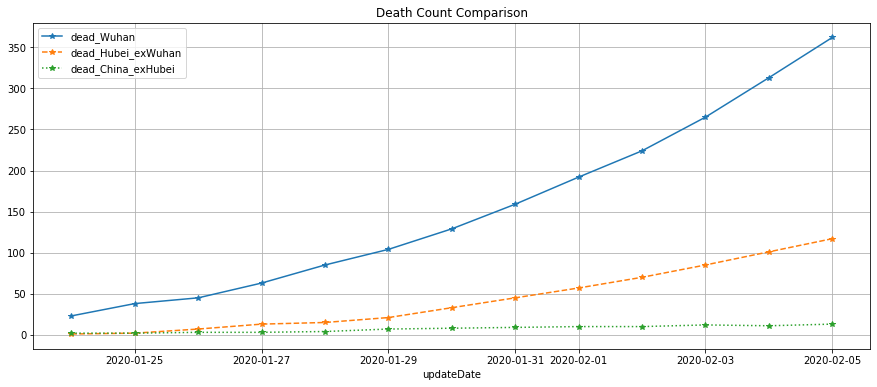

In [4]:
contrast_col = 'dead'    # you can pick other columns such as 'dead', 'cured'
locations = ('Wuhan', 'Hubei_exWuhan', 'China_exHubei')
contrast_frm.plot(y=[contrast_col + '_' + suffix for suffix in locations], grid=True, figsize=(15, 6), style=['-*', '--*', ':*'], 
                  title='Death Count Comparison')

从上图可以看出，武汉死亡人数远远超出湖北（武汉以外）以及其他全国各地死亡人数总和。这是为什么呢？一个可能原因是因为武汉确诊数目大，另一个可能原因是医疗条件饱和造成了死亡。

如果是第一个原因的话，那么死亡人数/确诊人数应该在各个区域都接近。下面检查一下这个假设：

In [5]:
for loc in locations:
    contrast_frm['simpleDeathRate_' + loc] = contrast_frm['dead_' + loc] / contrast_frm['confirmed_' + loc]

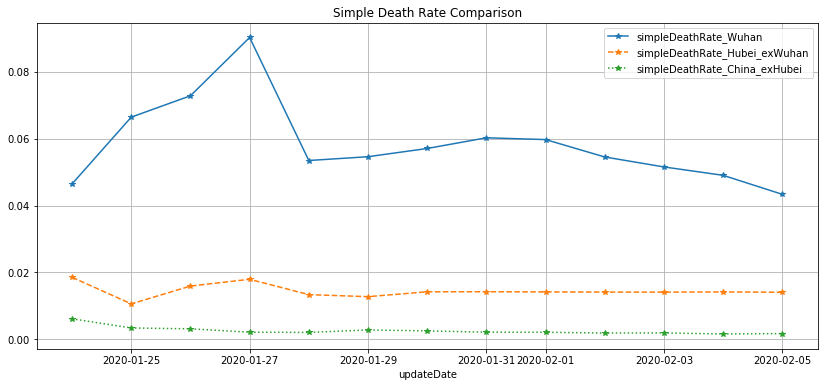

In [6]:
contrast_frm.plot(y=['simpleDeathRate_' + loc for loc in locations], grid=True, figsize=(14, 6), style=['-*', '--*', ':*'],
                 title='Simple Death Rate Comparison')

从上图可以看出，武汉死亡率 > 湖北（除武汉外）死亡率 > 全国其他地区死亡率

这说明武汉死亡人数高不是因为确诊人数多造成的。但是我们知道，死亡人数应该比确诊人数有个滞后，会不会是这个滞后造成计算不准确呢？

In [7]:
def lagDeathRate(df, location, lag=5):
    return np.mean(df['dead_' + location][lag:].to_numpy() / df['confirmed_' + location][:-lag].to_numpy())

In [8]:
print('延迟死亡率')
print('武汉：', "{:.2%}".format(lagDeathRate(contrast_frm, 'Wuhan')))
print('湖北（除武汉）：', "{:.2%}".format(lagDeathRate(contrast_frm, 'Hubei_exWuhan')))
print('全国（除湖北）：', "{:.2%}".format(lagDeathRate(contrast_frm, 'China_exHubei')))

延迟死亡率
武汉： 19.04%
湖北（除武汉）： 11.73%
全国（除湖北）： 0.85%


可见死亡统计的延迟效应并不影响 

武汉死亡率 > 湖北（除武汉外）死亡率 > 全国其他地区死亡率

的结论。

**那么是不是医疗系统饱和造成武汉、湖北死亡率高呢？**